# Handwritten Nepali Barnamal Recognition using KNN, Random Fprest and CNN models

# --- Setup and Imports ---

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # For image loading and manipulation
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns # For better confusion matrix visualization

# For Google Colab: Mount Google Drive to access your dataset
try:
    from google.colab import drive
    drive.mount('/content/drive')
    COLAB = True
    print("Google Colab environment detected. Google Drive mounted.")
except ImportError:
    COLAB = False
    print("Not in Google Colab environment. Assuming local execution.")


if COLAB:
    # Path to the zip file in your Google Drive (adjust if different)
    zip_path_in_drive = '/content/drive/MyDrive/DevanagariHandwrittenCharacterDataset.zip'
    # Destination directory to unzip in Colab
    unzip_dest_path = '/content/'
    print(f"Attempting to unzip {zip_path_in_drive} to {unzip_dest_path}...")
    # Unzip the dataset
    !unzip -q "{zip_path_in_drive}" -d "{unzip_dest_path}"
    print("Unzipping complete.")
    # Set the DATA_DIR to the extracted folder in /content/
    DATA_DIR = os.path.join(unzip_dest_path, 'DevanagariHandwrittenCharacterDataset')
else:
    # Local path for testing outside Colab (adjust for your local machine if needed)
    DATA_DIR = 'C:/Users/purug/Desktop/Nepali-Baenamala/DevanagariHandwrittenCharacterDataset'

print(f"Dataset base directory set to: {DATA_DIR}")
print(f"Contents of {DATA_DIR}:")
!ls -F "{DATA_DIR}" # Use !ls -F to list contents in Colab/Linux, or !dir /AD /B in Windows

# --- Data Loading and Preprocessing ---

In [ ]:
def load_images_from_directory(base_dir):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    print(f"Found {len(class_names)} classes: {class_names}")

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        image_files = glob.glob(os.path.join(class_dir, '*.png')) # Assuming PNG images

        print(f"Loading images from: {class_dir} ({len(image_files)} files)")

        for img_file in image_files:
            try:
                # Open image, convert to grayscale, resize to 32x32 (if not already), and flatten
                img = Image.open(img_file).convert('L') # 'L' for grayscale
                img = img.resize((32, 32)) # Ensure 32x32
                img_array = np.array(img).flatten() # Flatten to 1D array (1024 pixels)
                images.append(img_array)
                labels.append(class_to_idx[class_name])
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

    return np.array(images), np.array(labels), class_names

# Define paths for training and testing data
train_data_dir = os.path.join(DATA_DIR, 'Train')
test_data_dir = os.path.join(DATA_DIR, 'Test')

print("\n--- Loading Training Data ---")
X_train_raw, y_train, class_names = load_images_from_directory(train_data_dir)
print(f"Training data loaded: X_train_raw shape {X_train_raw.shape}, y_train shape {y_train.shape}")

print("\n--- Loading Testing Data ---")
X_test_raw, y_test, _ = load_images_from_directory(test_data_dir) # Use '_' for class_names as it's the same as train
print(f"Testing data loaded: X_test_raw shape {X_test_raw.shape}, y_test shape {y_test.shape}")

# Normalize pixel values to [0, 1]
# Convert to float32 first to avoid integer division issues
X_train_normalized = X_train_raw.astype('float32') / 255.0
X_test_normalized = X_test_raw.astype('float32') / 255.0

print("\nData Preprocessing Complete:")
print(f"X_train_normalized shape: {X_train_normalized.shape}")
print(f"X_test_normalized shape: {X_test_normalized.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class mapping: {class_names}")

# Display a few sample images to verify
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Reshape the 1D array back to 32x32 for visualization
    plt.imshow(X_train_normalized[i].reshape(32, 32), cmap='gray')
    plt.title(f"Label: {class_names[y_train[i]]}")
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()

# --- Model Training (K-Nearest Neighbors) ---

In [ ]:
print("\n--- Training K-Nearest Neighbors Model ---")

# Initialize the KNN classifier
# n_neighbors: number of neighbors to consider for classification. Default is 5.
# We will use the default for now.
# n_jobs=-1 uses all available CPU cores for computation, which can speed up training and prediction.
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Train the model using the normalized training data
print(f"Training KNN model with {knn_model.n_neighbors} neighbors...")
knn_model.fit(X_train_normalized, y_train)
print("KNN Model Training Complete!")




# --- Model Evaluation ---

In [ ]:
print("\n--- Evaluating K-Nearest Neighbors Model ---")

# Make predictions on the normalized test data
print("Making predictions on the test set...")
y_pred = knn_model.predict(X_test_normalized)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Generate and print the Classification Report
# This provides precision, recall, f1-score, and support for each class
print("\nClassification Report:")
# Ensure class_names are passed to classification_report for better readability
print(classification_report(y_test, y_pred, target_names=class_names))

# Generate and plot the Confusion Matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 12)) # Adjust figure size for better visibility of many classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Classifier')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\n--- KNN Model Evaluation Complete ---")

# --- Hyperparameter Tuning for KNN using RandomizedSearchCV ---

## NOT done (too time consuming) here, Done below using GPU setup

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

print("\n--- Starting Hyperparameter Tuning for KNN using RandomizedSearchCV ---")

# Define the parameter distribution to sample from
# We'll search for optimal 'n_neighbors', 'weights', and 'metric'
# Note: For RandomizedSearchCV, it's often better to give a wider range
# and let it sample, but we'll keep it similar for direct comparison.
param_dist = {
    'n_neighbors': np.arange(3, 22, 2), # Values from 3 to 21, step 2 (odd numbers)
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the KNN classifier
knn_base = KNeighborsClassifier(n_jobs=-1)

# Initialize RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled. (Crucial for speed!)
#   A good starting point is 10, 20, or 50.
#   Each iteration means one full cross-validation run for one random combination.
# cv: Number of folds for cross-validation. Still using 5.
# scoring: The metric to optimize.
# verbose: Controls verbosity.
# random_state: For reproducibility of the random sampling.
random_search = RandomizedSearchCV(estimator=knn_base,
                                   param_distributions=param_dist,
                                   n_iter=20, # Try 20 random combinations (can adjust this)
                                   cv=5,
                                   scoring='accuracy',
                                   verbose=2,
                                   random_state=42, # For reproducible results
                                   n_jobs=-1)

# Fit RandomizedSearchCV to the training data
print(f"Running RandomizedSearchCV (sampling {random_search.n_iter} combinations, this will be faster)...")
random_search.fit(X_train_normalized, y_train)

print("\n--- Randomized Hyperparameter Tuning Complete ---")

# Print the best parameters found
print(f"Best parameters found: {random_search.best_params_}")

# Print the best score achieved during cross-validation
print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

# Get the best model from the random search
best_knn_model = random_search.best_estimator_

# --- Evaluate Best KNN Model on the Test Set (same as before) ---

print("\n--- Evaluating Best KNN Model on the Test Set (from Randomized Search) ---")

y_pred_tuned = best_knn_model.predict(X_test_normalized)

# Calculate Accuracy
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nAccuracy (Tuned KNN): {accuracy_tuned:.4f}")

# Generate and print the Classification Report
print("\nClassification Report (Tuned KNN):")
print(classification_report(y_test, y_pred_tuned, target_names=class_names))

# Generate and plot the Confusion Matrix for the tuned model
print("\nGenerating Confusion Matrix for Tuned KNN...")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned KNN Classifier (Randomized Search)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- Tuned KNN Model Evaluation Complete ---")

# KNN

# Start from here
# --- GPU Acceleration Setup --- (for above) KNN

Google Colab environment detected.
Thu Jul 17 14:13:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------

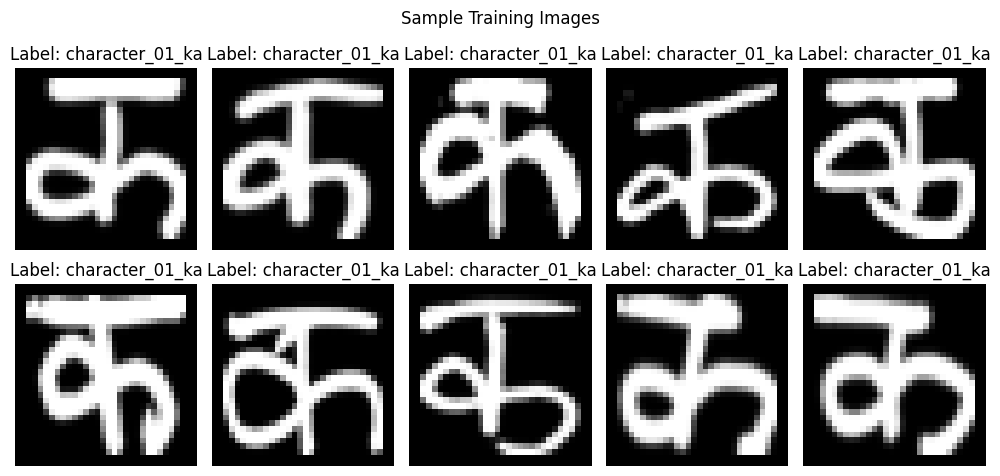


--- Starting Hyperparameter Tuning for KNN using RandomizedSearchCV (GPU) ---
Running RandomizedSearchCV for KNN (sampling 20 combinations, using GPU)...
[2025-07-17 14:14:43.453] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[2025-07-17 14:14:43.468] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END .metric=euclidean, n_neighbors=21, weights=distance; total time=   4.5s
[2025-07-17 14:14:48.006] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END .metric=euclidean, n_neighbors=21, weights=distance; total time=   1.8s
[2025-07-17 14:14:49.839] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END .metric=euclidean, n_neighbors=21, weights=distance; total time=   1.8s
[2025-07-17 14:14:51.663] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initi

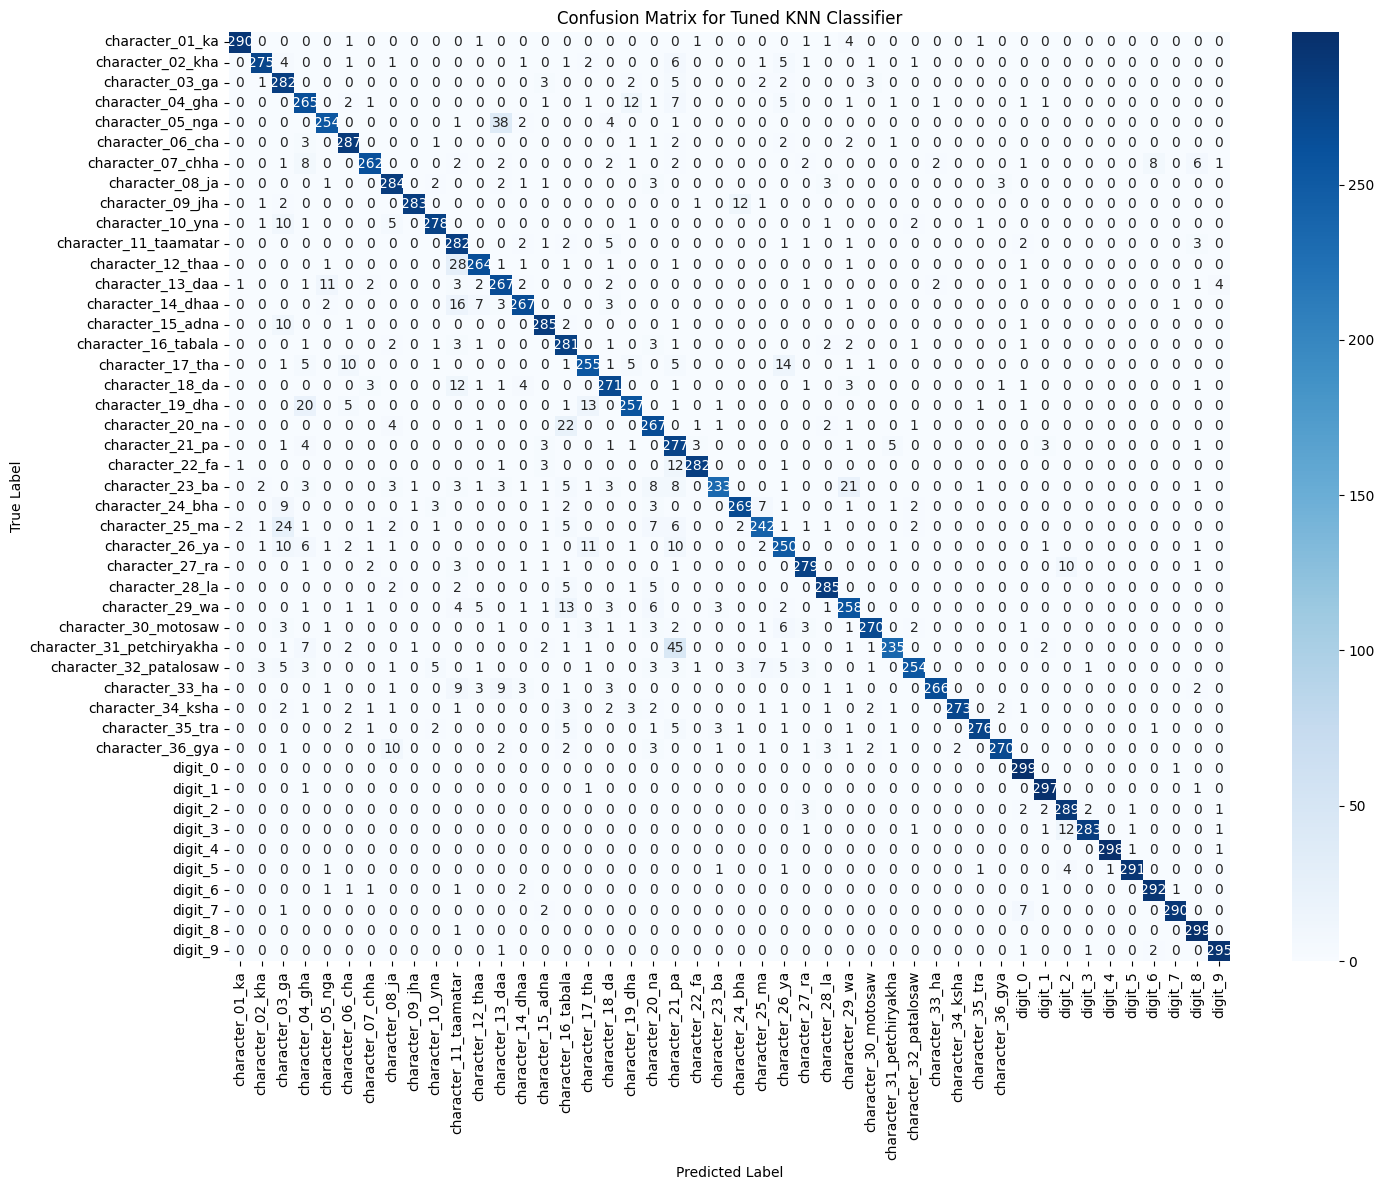


--- Tuned KNN Model Evaluation Complete (GPU) ---


In [ ]:
# This cell needs to be run only once per Colab session.
# It installs RAPIDS cuML, which provides GPU-accelerated ML algorithms.

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import glob # Import glob here

# Check if running in Google Colab and if GPU is available
if 'google.colab' in sys.modules:
    COLAB = True
    print("Google Colab environment detected.")
    # Check for GPU
    !nvidia-smi
    if not os.path.exists('/opt/bin/nvidia-smi'):
        print("WARNING: GPU not detected. Please change runtime type to GPU.")
    else:
        print("GPU detected. Proceeding with cuML installation.")
else:
    COLAB = False
    print("Not in Google Colab environment. GPU acceleration will not be applied.")


if COLAB:
    # Install RAPIDS cuML. The exact command depends on the CUDA version.
    # This command is generally robust for Colab.
    # It might take a few minutes to complete.
    print("Installing RAPIDS cuML. This may take a few minutes...")
    !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com/
    print("cuML installation complete.")

    # Import GPU-accelerated versions of models
    from cuml.neighbors import KNeighborsClassifier as cuKNN
    from cuml.svm import SVC as cuSVC
    from sklearn.model_selection import RandomizedSearchCV # GridSearchCV/RandomizedSearchCV are still from sklearn
    from scipy.stats import reciprocal, uniform

    # Mount Google Drive (if your dataset is stored there)
    from google.colab import drive
    drive.mount('/content/drive')

    # Define the base path for your dataset
    # IMPORTANT: Adjust this path based on where you uploaded/extracted your dataset in Drive.
    zip_path_in_drive = '/content/drive/MyDrive/DevanagariHandwrittenCharacterDataset.zip'
    unzip_dest_path = '/content/'
    print(f"Attempting to unzip {zip_path_in_drive} to {unzip_dest_path}...")
    # Unzip the dataset quietly (-q) into the destination path (-d)
    !unzip -q "{zip_path_in_drive}" -d "{unzip_dest_path}"
    print("Unzipping complete.")
    DATA_DIR = os.path.join(unzip_dest_path, 'DevanagariHandwrittenCharacterDataset')
else:
    # Fallback to CPU scikit-learn if not in Colab
    from sklearn.neighbors import KNeighborsClassifier as cuKNN
    from sklearn.svm import SVC as cuSVC
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import reciprocal, uniform
    DATA_DIR = 'C:/Users/purug/Desktop/Nepali-Baenamala/DevanagariHandwrittenCharacterDataset' # Local path for testing

print(f"Dataset base directory set to: {DATA_DIR}")
print(f"Contents of {DATA_DIR}:")
!ls -F "{DATA_DIR}"


# --- Data Loading and Preprocessing (Same as before) ---

def load_images_from_directory(base_dir):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    print(f"Found {len(class_names)} classes: {class_names}")

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        image_files = glob.glob(os.path.join(class_dir, '*.png'))

        # print(f"Loading images from: {class_dir} ({len(image_files)} files)") # Can be verbose for many classes

        for img_file in image_files:
            try:
                img = Image.open(img_file).convert('L')
                img = img.resize((32, 32))
                img_array = np.array(img).flatten()
                images.append(img_array)
                labels.append(class_to_idx[class_name])
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

    return np.array(images), np.array(labels), class_names

# Define paths for training and testing data
train_data_dir = os.path.join(DATA_DIR, 'Train')
test_data_dir = os.path.join(DATA_DIR, 'Test')

print("\n--- Loading Training Data ---")
X_train_raw, y_train, class_names = load_images_from_directory(train_data_dir)
print(f"Training data loaded: X_train_raw shape {X_train_raw.shape}, y_train shape {y_train.shape}")

print("\n--- Loading Testing Data ---")
X_test_raw, y_test, _ = load_images_from_directory(test_data_dir)
print(f"Testing data loaded: X_test_raw shape {X_test_raw.shape}, y_test shape {y_test.shape}")

# Normalize pixel values to [0, 1]
X_train_normalized = X_train_raw.astype('float32') / 255.0
X_test_normalized = X_test_raw.astype('float32') / 255.0

print("\nData Preprocessing Complete:")
print(f"X_train_normalized shape: {X_train_normalized.shape}")
print(f"X_test_normalized shape: {X_test_normalized.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class mapping: {class_names}")

# Display a few sample images to verify
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_normalized[i].reshape(32, 32), cmap='gray')
    plt.title(f"Label: {class_names[y_train[i]]}")
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()


# --- Hyperparameter Tuning for KNN using RandomizedSearchCV (GPU-accelerated) ---

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\n--- Starting Hyperparameter Tuning for KNN using RandomizedSearchCV (GPU) ---")

# Define the parameter distribution to sample from
param_dist_knn = {
    'n_neighbors': np.arange(3, 22, 2), # Values from 3 to 21, step 2 (odd numbers)
    'weights': ['uniform', 'distance'], # How to weight the neighbors
    'metric': ['euclidean', 'manhattan'] # Distance metric
}

# Initialize the GPU-accelerated KNN classifier
# cuML models don't use n_jobs=-1 directly, as they manage GPU parallelism internally.
# For cuML, ensure data is on GPU if you're doing complex operations, but for fit/predict,
# it often handles transfer internally.
knn_base_gpu = cuKNN()

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(estimator=knn_base_gpu,
                                   param_distributions=param_dist_knn,
                                   n_iter=20, # Number of random combinations to try
                                   cv=5,
                                   scoring='accuracy',
                                   verbose=2,
                                   random_state=42, # For reproducible results
                                   n_jobs=1) # Set n_jobs=1 for cuML as it uses GPU for parallelism

# Fit RandomizedSearchCV to the training data
print(f"Running RandomizedSearchCV for KNN (sampling {random_search_knn.n_iter} combinations, using GPU)...")
random_search_knn.fit(X_train_normalized, y_train)

print("\n--- GPU-accelerated KNN Hyperparameter Tuning Complete ---")

# Print the best parameters found
print(f"Best parameters found for KNN: {random_search_knn.best_params_}")

# Print the best score achieved during cross-validation
print(f"Best cross-validation accuracy for KNN: {random_search_knn.best_score_:.4f}")

# Get the best KNN model from the random search
best_knn_model_gpu = random_search_knn.best_estimator_

# --- 6. Evaluate Best KNN Model on the Test Set (GPU-accelerated) ---

print("\n--- Evaluating Best KNN Model on the Test Set (GPU) ---")

y_pred_knn_gpu = best_knn_model_gpu.predict(X_test_normalized)

# Calculate Accuracy
accuracy_knn_gpu = accuracy_score(y_test, y_pred_knn_gpu)
print(f"\nAccuracy (Tuned KNN - GPU): {accuracy_knn_gpu:.4f}")

# Generate and print the Classification Report
print("\nClassification Report (Tuned KNN - GPU):")
print(classification_report(y_test, y_pred_knn_gpu, target_names=class_names))

# Generate and plot the Confusion Matrix for the tuned KNN model
print("\nGenerating Confusion Matrix for Tuned KNN (GPU)...")
cm_knn_gpu = confusion_matrix(y_test, y_pred_knn_gpu)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_knn_gpu, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned KNN Classifier')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- Tuned KNN Model Evaluation Complete (GPU) ---")

# Random Forest MOdel

Google Colab environment detected.
Thu Jul 17 14:18:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             32W /   70W |     414MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------

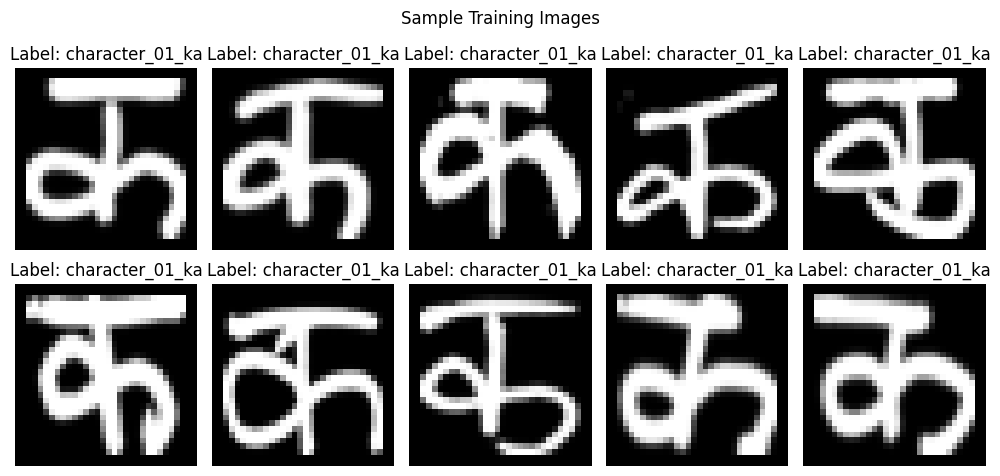


--- Starting Hyperparameter Tuning for Random Forest using RandomizedSearchCV (GPU) ---
Running RandomizedSearchCV for Random Forest (sampling 15 combinations, using GPU)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recomm

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.7s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.3s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.4s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.6s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.6s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  10.9s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  11.2s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  11.0s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  18.5s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  19.0s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  18.9s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.1s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py", line 193, in wrapper
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py", line 416, in dispatch
    return self.dispatch_func(func_name, gpu_


--- GPU-accelerated Random Forest Hyperparameter Tuning Complete ---
Best parameters found for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}
Best cross-validation accuracy for Random Forest: 0.8919

--- Evaluating Best Random Forest Model on the Test Set (GPU) ---

Accuracy (Tuned Random Forest - GPU): 0.9091

Classification Report (Tuned Random Forest - GPU):
                           precision    recall  f1-score   support

          character_01_ka       0.93      0.96      0.94       300
         character_02_kha       0.95      0.87      0.91       300
          character_03_ga       0.93      0.87      0.90       300
         character_04_gha       0.84      0.83      0.84       300
         character_05_nga       0.95      0.91      0.93       300
         character_06_cha       0.88      0.92      0.90       300
        character_07_chha       0.92      0.79      0.85       300
 

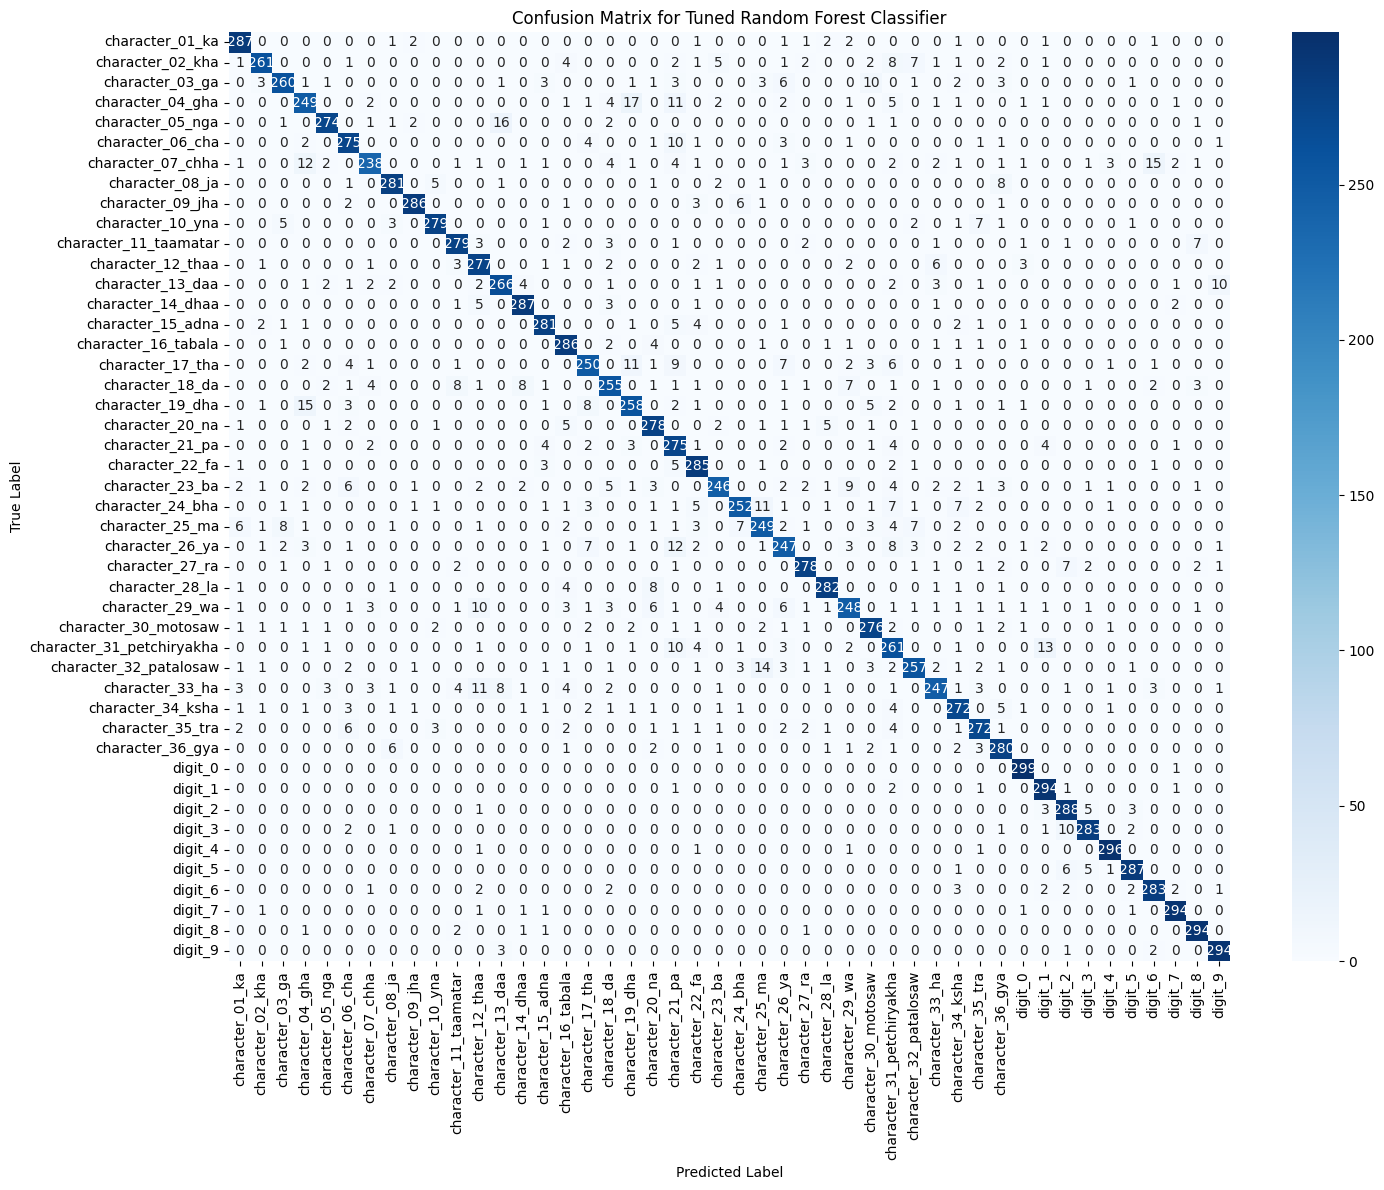


--- Tuned Random Forest Model Evaluation Complete (GPU) ---


In [ ]:
# --- GPU Acceleration Setup ---
# This cell needs to be run only once per Colab session.
# It installs RAPIDS cuML, which provides GPU-accelerated ML algorithms.

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import glob # For listing files

# Check if running in Google Colab and if GPU is available
if 'google.colab' in sys.modules:
    COLAB = True
    print("Google Colab environment detected.")
    # Check for GPU
    !nvidia-smi
    if not os.path.exists('/opt/bin/nvidia-smi'):
        print("WARNING: GPU not detected. Please change runtime type to GPU.")
    else:
        print("GPU detected. Proceeding with cuML installation.")
else:
    COLAB = False
    print("Not in Google Colab environment. GPU acceleration will not be applied.")


if COLAB:
    # Install RAPIDS cuML. The exact command depends on the CUDA version.
    # This command is generally robust for Colab.
    # It might take a few minutes to complete.
    print("Installing RAPIDS cuML. This may take a few minutes...")
    # Using --no-cache-dir to avoid issues with cached packages
    !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com/ --no-cache-dir
    print("cuML installation complete.")

    # Import GPU-accelerated versions of models
    from cuml.ensemble import RandomForestClassifier as cuRandomForest # Alias for clarity
    from sklearn.model_selection import RandomizedSearchCV # Still from sklearn
    from scipy.stats import reciprocal, uniform # For parameter distributions

    # Mount Google Drive (if your dataset is stored there)
    from google.colab import drive
    drive.mount('/content/drive')

    # Define the base path for your dataset
    # IMPORTANT: Adjust this path based on where you uploaded/extracted your dataset in Drive.
    zip_path_in_drive = '/content/drive/MyDrive/DevanagariHandwrittenCharacterDataset.zip'
    unzip_dest_path = '/content/'
    print(f"Attempting to unzip {zip_path_in_drive} to {unzip_dest_path}...")
    # Unzip the dataset quietly (-q) into the destination path (-d)
    # Use -o to overwrite if it already exists, -qq for even quieter output
    !unzip -qq -o "{zip_path_in_drive}" -d "{unzip_dest_path}"
    print("Unzipping complete.")
    DATA_DIR = os.path.join(unzip_dest_path, 'DevanagariHandwrittenCharacterDataset')
else:
    # Fallback to CPU scikit-learn if not in Colab
    from sklearn.ensemble import RandomForestClassifier as cuRandomForest
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import reciprocal, uniform
    DATA_DIR = 'C:/Users/purug/Desktop/Nepali-Baenamala/DevanagariHandwrittenCharacterDataset' # Local path for testing

print(f"Dataset base directory set to: {DATA_DIR}")
print(f"Contents of {DATA_DIR}:")
!ls -F "{DATA_DIR}"


# --- Data Loading and Preprocessing (Same as before) ---

def load_images_from_directory(base_dir):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    print(f"Found {len(class_names)} classes: {class_names}")

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        image_files = glob.glob(os.path.join(class_dir, '*.png'))

        # print(f"Loading images from: {class_dir} ({len(image_files)} files)") # Can be verbose for many classes

        for img_file in image_files:
            try:
                img = Image.open(img_file).convert('L')
                img = img.resize((32, 32))
                img_array = np.array(img).flatten()
                images.append(img_array)
                labels.append(class_to_idx[class_name])
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

    return np.array(images), np.array(labels), class_names

# Define paths for training and testing data
train_data_dir = os.path.join(DATA_DIR, 'Train')
test_data_dir = os.path.join(DATA_DIR, 'Test')

print("\n--- Loading Training Data ---")
X_train_raw, y_train, class_names = load_images_from_directory(train_data_dir)
print(f"Training data loaded: X_train_raw shape {X_train_raw.shape}, y_train shape {y_train.shape}")

print("\n--- Loading Testing Data ---")
X_test_raw, y_test, _ = load_images_from_directory(test_data_dir)
print(f"Testing data loaded: X_test_raw shape {X_test_raw.shape}, y_test shape {y_test.shape}")

# Normalize pixel values to [0, 1]
X_train_normalized = X_train_raw.astype('float32') / 255.0
X_test_normalized = X_test_raw.astype('float32') / 255.0

print("\nData Preprocessing Complete:")
print(f"X_train_normalized shape: {X_train_normalized.shape}")
print(f"X_test_normalized shape: {X_test_normalized.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class mapping: {class_names}")

# Display a few sample images to verify
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_normalized[i].reshape(32, 32), cmap='gray')
    plt.title(f"Label: {class_names[y_train[i]]}")
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()


# --- Implement and Tune Random Forest Classifier (GPU-accelerated) ---

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\n--- Starting Hyperparameter Tuning for Random Forest using RandomizedSearchCV (GPU) ---")

# Initialize the GPU-accelerated Random Forest classifier
rf_base_gpu = cuRandomForest(random_state=42) # Set random_state for reproducibility

# Define the parameter distribution to sample from for Random Forest
# Reduced ranges and n_iter for faster execution on free Colab tier
param_dist_rf = {
    'n_estimators': [50, 100, 200], # Fewer trees to speed up
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None], # Fewer depth options
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True] # Often True is preferred for Random Forest
}

# Initialize RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(estimator=rf_base_gpu,
                                      param_distributions=param_dist_rf,
                                      n_iter=15, # Significantly reduced iterations for speed
                                      cv=3, # Reduced cross-validation folds for speed
                                      scoring='accuracy',
                                      verbose=2,
                                      random_state=42,
                                      n_jobs=1) # Set n_jobs=1 for cuML (GPU handles parallelism)

# Fit RandomizedSearchCV to the training data
print(f"Running RandomizedSearchCV for Random Forest (sampling {random_search_rf.n_iter} combinations, using GPU)...")
random_search_rf.fit(X_train_normalized, y_train)

print("\n--- GPU-accelerated Random Forest Hyperparameter Tuning Complete ---")

# Print the best parameters found
print(f"Best parameters found for Random Forest: {random_search_rf.best_params_}")

# Print the best score achieved during cross-validation
print(f"Best cross-validation accuracy for Random Forest: {random_search_rf.best_score_:.4f}")

# Get the best Random Forest model from the random search
best_rf_model_gpu = random_search_rf.best_estimator_

# --- Evaluate Best Random Forest Model on the Test Set (GPU-accelerated) ---

print("\n--- Evaluating Best Random Forest Model on the Test Set (GPU) ---")

y_pred_rf_gpu = best_rf_model_gpu.predict(X_test_normalized)

# Calculate Accuracy
accuracy_rf_gpu = accuracy_score(y_test, y_pred_rf_gpu)
print(f"\nAccuracy (Tuned Random Forest - GPU): {accuracy_rf_gpu:.4f}")

# Generate and print the Classification Report
print("\nClassification Report (Tuned Random Forest - GPU):")
print(classification_report(y_test, y_pred_rf_gpu, target_names=class_names))

# Generate and plot the Confusion Matrix for the tuned Random Forest model
print("\nGenerating Confusion Matrix for Tuned Random Forest (GPU)...")
cm_rf_gpu = confusion_matrix(y_test, y_pred_rf_gpu)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_rf_gpu, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned Random Forest Classifier')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- Tuned Random Forest Model Evaluation Complete (GPU) ---")


# --- Implement Convolutional Neural Network (CNN) ---


--- Data Reshaped for CNN ---
X_train_cnn shape: (78200, 32, 32, 1)
X_test_cnn shape: (13800, 32, 32, 1)
y_train_one_hot shape: (78200, 46)
y_test_one_hot shape: (13800, 46)

--- Defining CNN Model Architecture ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,790 (1.22 MB)

 Trainable params: 319,790 (1.22 MB)

 Non-trainable params: 0 (0.00 B)


--- Training CNN Model ---
Epoch 1/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3746 - loss: 2.3386 - val_accuracy: 0.9023 - val_loss: 0.3719
Epoch 2/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7861 - loss: 0.7080 - val_accuracy: 0.9377 - val_loss: 0.2250
Epoch 3/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8436 - loss: 0.5032 - val_accuracy: 0.9504 - val_loss: 0.1691
Epoch 4/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8737 - loss: 0.4122 - val_accuracy: 0.9606 - val_loss: 0.1336
Epoch 5/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8895 - loss: 0.3575 - val_accuracy: 0.9680 - val_loss: 0.1142
Epoch 6/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9024 - loss: 0.3117 - val_accuracy: 0.9689 - val_loss: 0.1089
Epoch 7/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9114 - loss: 0.2832 - val_accuracy: 0.9713 - val_loss: 0.0980
Epoch 8/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9150 - l

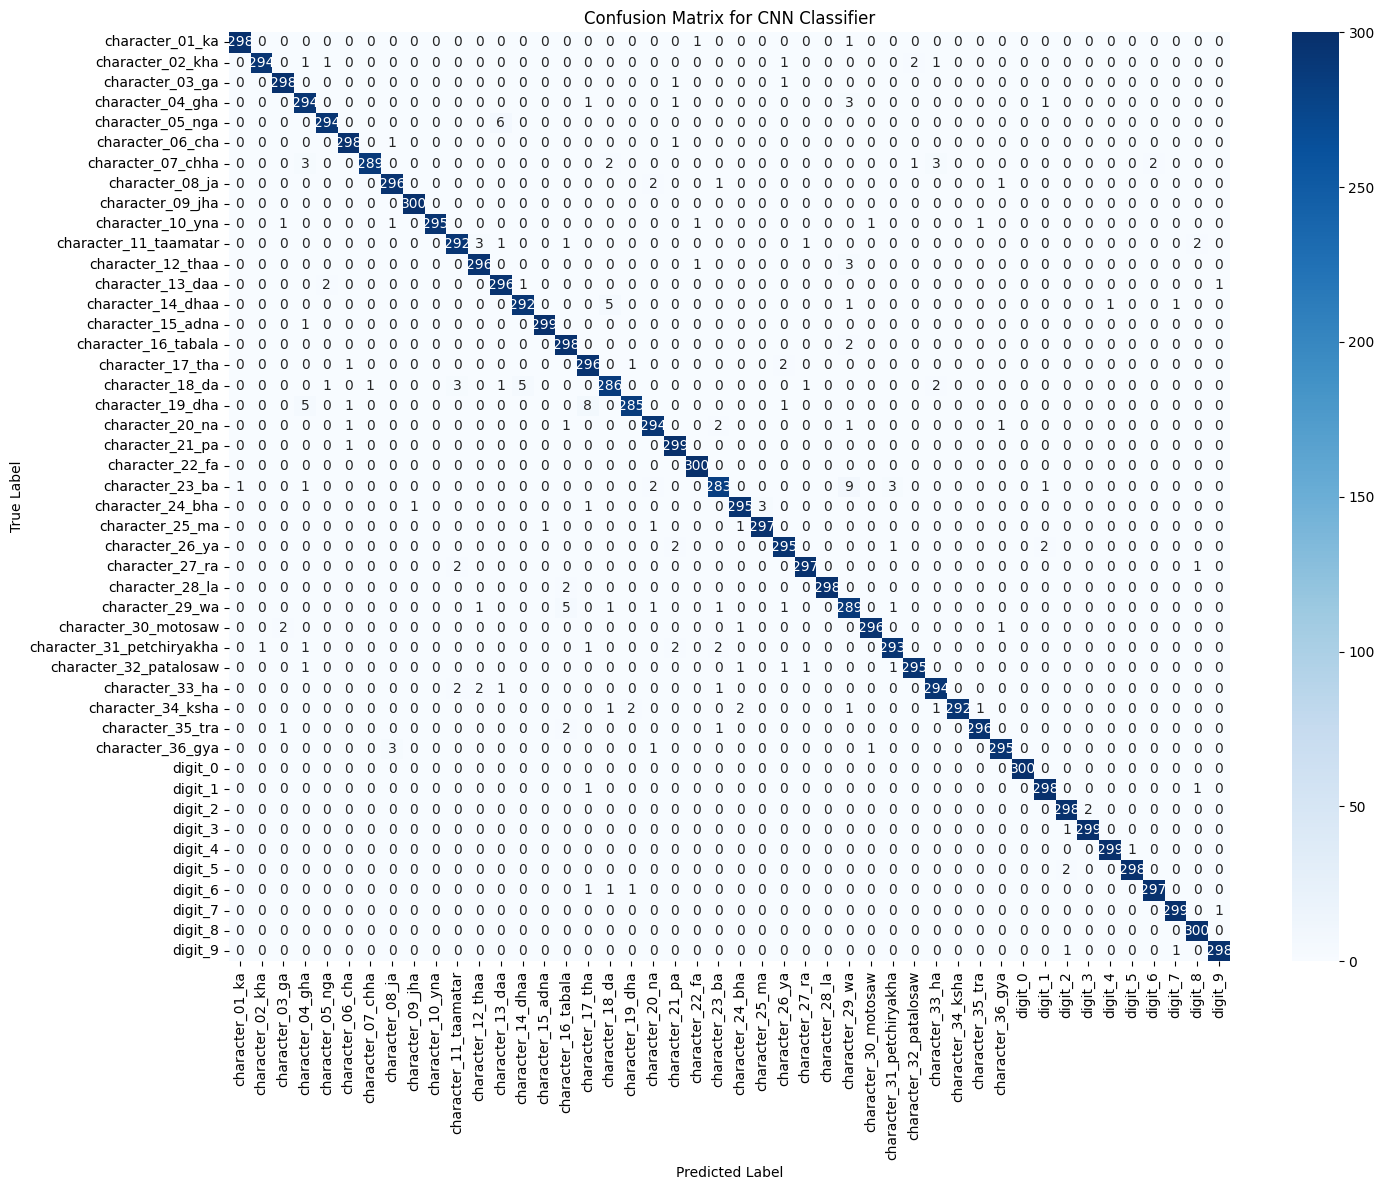


--- CNN Model Evaluation Complete ---

--- Plotting Training and Validation Curves ---


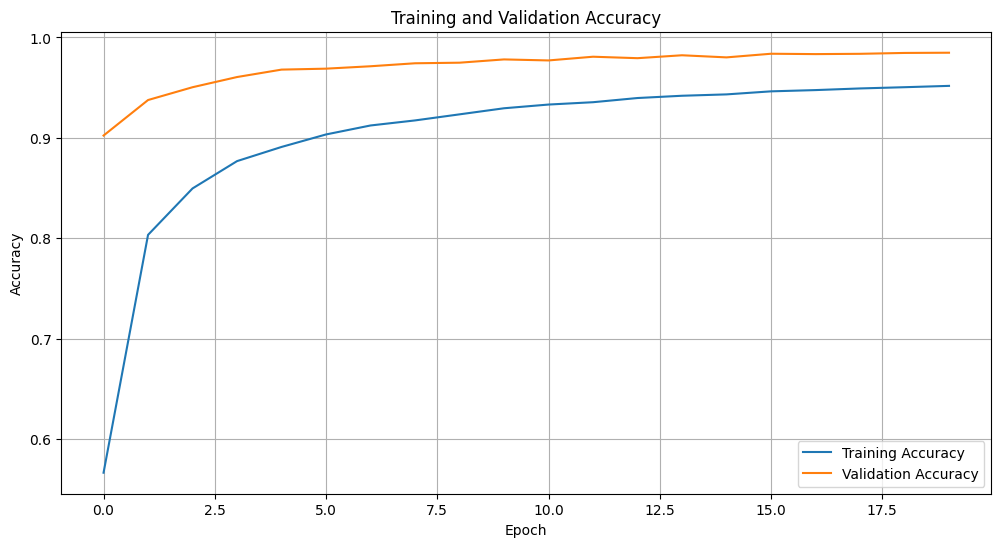

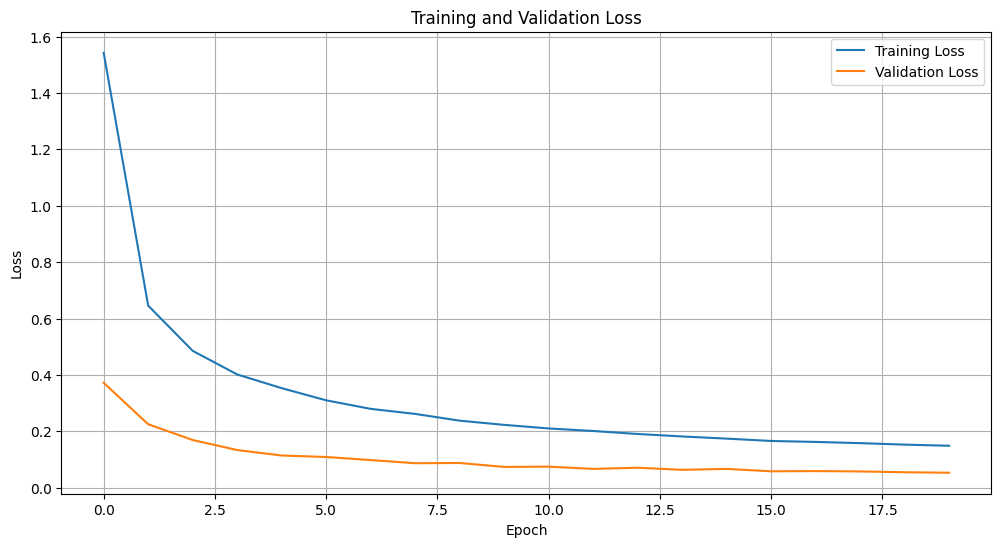


--- Plotting Complete ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os # Ensure os is imported for data path management
import glob # Ensure glob is imported for file listing
from PIL import Image # Ensure PIL is imported for image loading

# --- Data Reshaping for CNN ---
# CNNs expect input in (batch_size, height, width, channels) format.
# Your images are 32x32 grayscale, so channels = 1.

# Reshape X_train_normalized and X_test_normalized
# Make sure your data is float32 as expected by TensorFlow
X_train_cnn = X_train_normalized.reshape(-1, 32, 32, 1).astype('float32')
X_test_cnn = X_test_normalized.reshape(-1, 32, 32, 1).astype('float32')

# Convert labels to one-hot encoding for categorical crossentropy loss
# num_classes should be determined from your loaded data, e.g., len(class_names)
num_classes = len(class_names)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("\n--- Data Reshaped for CNN ---")
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")
print(f"y_test_one_hot shape: {y_test_one_hot.shape}")


# --- Define the CNN Model Architecture ---

print("\n--- Defining CNN Model Architecture ---")

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Added dropout for regularization

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output for the Dense layers
    Flatten(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5), # Added dropout for regularization
    Dense(num_classes, activation='softmax') # Output layer with softmax for multi-class classification
])

# Compile the model
# Optimizer: Adam is a good general-purpose optimizer
# Loss: categorical_crossentropy for multi-class classification with one-hot encoded labels
# Metrics: accuracy to monitor performance during training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


# --- Train the CNN Model ---

print("\n--- Training CNN Model ---")

# Define training parameters
epochs = 20 # Number of training iterations over the entire dataset
batch_size = 128 # Number of samples per gradient update

# Train the model
# validation_data: Evaluate loss and metrics on the test set after each epoch
history = model.fit(X_train_cnn, y_train_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_cnn, y_test_one_hot),
                    verbose=1)

print("\n--- CNN Model Training Complete ---")


# --- Evaluate the CNN Model ---

print("\n--- Evaluating CNN Model ---")

# Evaluate the model on the test set
loss, accuracy_cnn = model.evaluate(X_test_cnn, y_test_one_hot, verbose=0)
print(f"\nAccuracy (CNN): {accuracy_cnn:.4f}")

# Make predictions
y_pred_cnn_probs = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1) # Convert probabilities to class labels

# Generate and print the Classification Report
print("\nClassification Report (CNN):")
print(classification_report(y_test, y_pred_cnn, target_names=class_names))

# Generate and plot the Confusion Matrix for the CNN model
print("\nGenerating Confusion Matrix for CNN...")
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN Classifier')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- CNN Model Evaluation Complete ---")


# --- Plot Training and Validation Curves ---

print("\n--- Plotting Training and Validation Curves ---")

# Get training and validation history
epochs_range = range(epochs)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("\n--- Plotting Complete ---")


# Extra Stuffs and Practice

## Not mentioned in the Report below here


--- Data Reshaped for CNN ---
X_train_cnn shape: (78200, 32, 32, 1)
X_test_cnn shape: (13800, 32, 32, 1)
y_train_one_hot shape: (78200, 46)
y_test_one_hot shape: (13800, 46)

--- Defining ENHANCED CNN Model Architecture ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 596,622 (2.28 MB)

 Trainable params: 595,982 (2.27 MB)

 Non-trainable params: 640 (2.50 KB)


--- Training ENHANCED CNN Model ---
Epoch 1/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5749 - loss: 1.6988 - val_accuracy: 0.9047 - val_loss: 0.3681
Epoch 2/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.9131 - loss: 0.3181 - val_accuracy: 0.9780 - val_loss: 0.0789
Epoch 3/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9446 - loss: 0.1980 - val_accuracy: 0.9812 - val_loss: 0.0679
Epoch 4/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9569 - loss: 0.1479 - val_accuracy: 0.9848 - val_loss: 0.0545
Epoch 5/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9639 - loss: 0.1216 - val_accuracy: 0.9858 - val_loss: 0.0481
Epoch 6/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9673 - loss: 0.1070 - val_accuracy: 0.9888 - val_loss: 0.0405
Epoch 7/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9726 - loss: 0.0903 - val_accuracy: 0.9886 - val_loss: 0.0371
Epoch 8/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - a

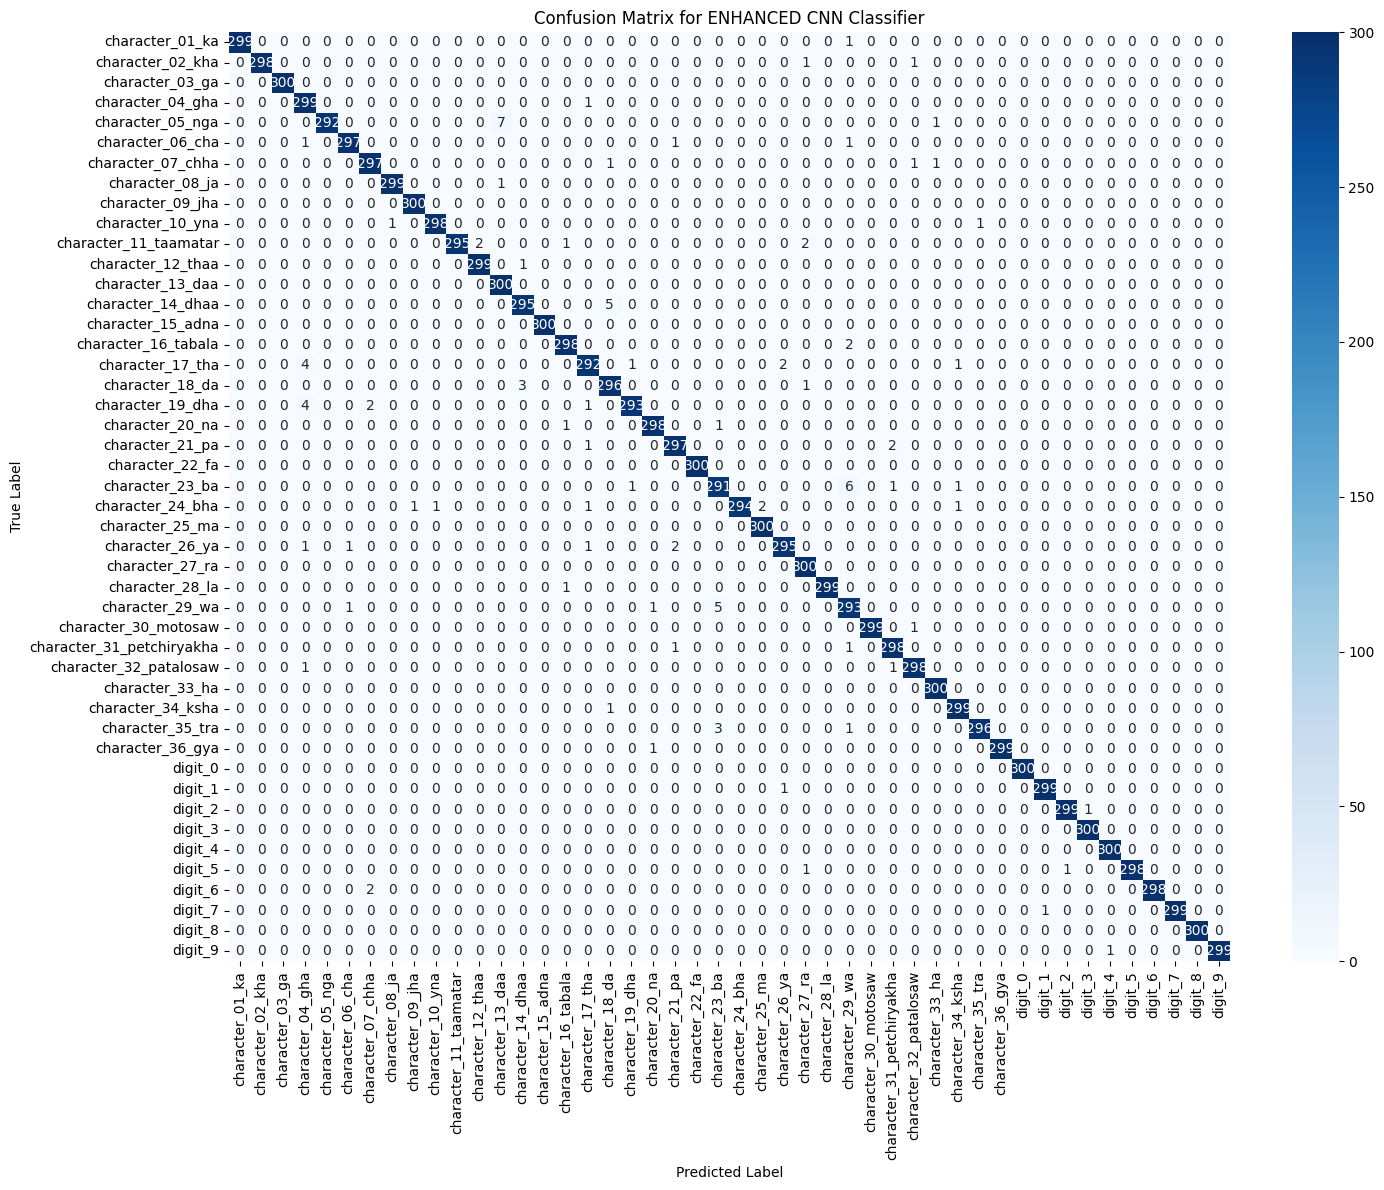


--- ENHANCED CNN Model Evaluation Complete ---

--- Plotting Training and Validation Curves ---


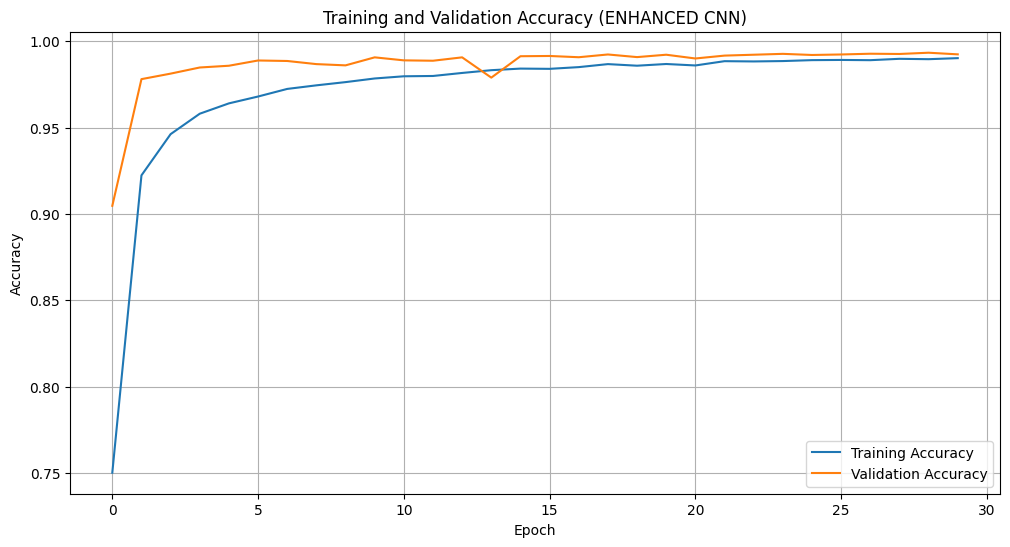

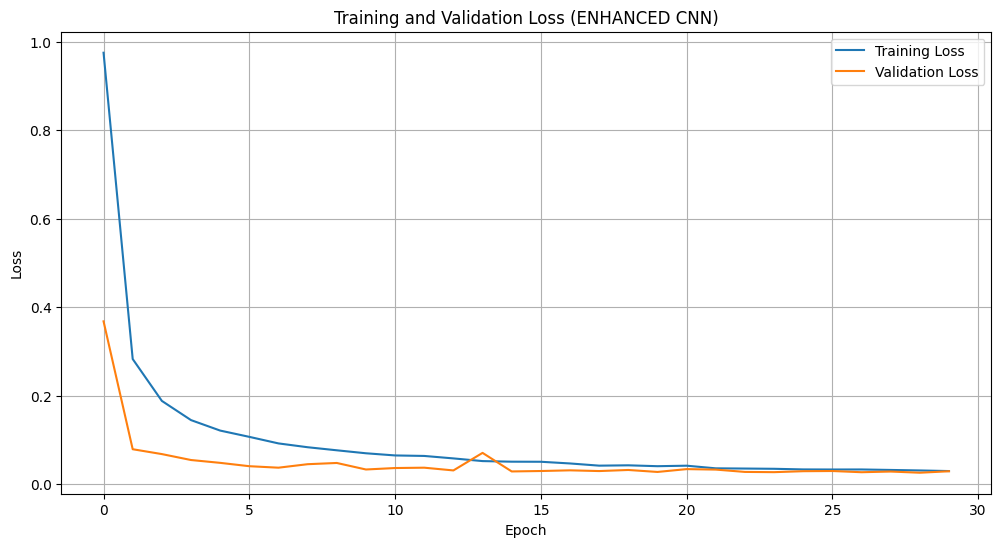


--- Plotting Complete ---


In [ ]:
# --- Implement Enhanced Convolutional Neural Network (CNN) ---

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from PIL import Image

# --- Data Reshaping for CNN ---
X_train_cnn = X_train_normalized.reshape(-1, 32, 32, 1).astype('float32')
X_test_cnn = X_test_normalized.reshape(-1, 32, 32, 1).astype('float32')

num_classes = len(class_names)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("\n--- Data Reshaped for CNN ---")
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")
print(f"y_test_one_hot shape: {y_test_one_hot.shape}")


# --- Define the ENHANCED CNN Model Architecture ---

print("\n--- Defining ENHANCED CNN Model Architecture ---")

model = Sequential([
    # First Convolutional Block (Increased depth and Batch Norm)
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 1)), # Added padding='same'
    BatchNormalization(), # Added Batch Normalization
    tf.keras.layers.Activation('relu'), # Explicit ReLU activation after BN

    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block (Increased depth and Batch Norm)
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output for the Dense layers
    Flatten(),

    # Fully Connected Layers (with Batch Norm)
    Dense(128),
    BatchNormalization(), # Added Batch Normalization
    tf.keras.layers.Activation('relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax') # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


# --- 12. Train the CNN Model ---

print("\n--- Training ENHANCED CNN Model ---")

epochs = 30 # Increased epochs slightly, can adjust based on plots
batch_size = 128

history = model.fit(X_train_cnn, y_train_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_cnn, y_test_one_hot),
                    verbose=1)

print("\n--- ENHANCED CNN Model Training Complete ---")


# --- 13. Evaluate the CNN Model ---

print("\n--- Evaluating ENHANCED CNN Model ---")

loss, accuracy_cnn = model.evaluate(X_test_cnn, y_test_one_hot, verbose=0)
print(f"\nAccuracy (ENHANCED CNN): {accuracy_cnn:.4f}")

y_pred_cnn_probs = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

print("\nClassification Report (ENHANCED CNN):")
print(classification_report(y_test, y_pred_cnn, target_names=class_names))

print("\nGenerating Confusion Matrix for ENHANCED CNN...")
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ENHANCED CNN Classifier')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- ENHANCED CNN Model Evaluation Complete ---")


# --- 14. Plot Training and Validation Curves ---

print("\n--- Plotting Training and Validation Curves ---")

epochs_range = range(epochs)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (ENHANCED CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (ENHANCED CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("\n--- Plotting Complete ---")
